# Production notebook

In [1]:
import os 
import sys
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.integrate import simpson

#from scipy.stats import *
#custom utilities: 
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from utils import config
from utils.config import *
from utils.preflight import *
from utils.plotstyle import *
from utils.production import *
from utils.stats import *
initialize_custom_style()

In [2]:
##configurable stuff: read the file, asign it to variables: 
root_dir = config.get_root_dir()
config_dict = config.readconfig(os.path.join(root_dir, 'config/config_production.json'))
data_dir = os.path.join(root_dir, config_dict['data_dir'])
binamount = config_dict['histbins']

## Reading data in Python:

In [3]:
#load all the data required for this task. 
#masterfile
master_production_data= pd.read_json(os.path.join(root_dir, config_dict['data_dir'], config_dict['masterfile']), typ='series')
production_data = pd.DataFrame(load_json_datafiles(os.path.join(root_dir, config_dict['data_dir'], config_dict['dailydirname'])))


## Inspecting read data

In [4]:
preflightchecks(production_data)
#not that great, but:
#   we learned that not a single column is truely unique!
#   maintainece is to be considered a boolean.
#   some values that should be ints, are objects! Why? 


,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.0,1.0,1,0.0,0.0,0.0,0.0,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,2,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,object,0,434,False,NaN,NaN,NaN,NaN,NaN,1244,NaN,NaN,NaN,NaN,None,None,None,None,None
6,prod_loss_perc,object,0,94,False,NaN,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,None,None,None,None,None
7,production,object,0,581,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,None,None,None,None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


In [5]:
#drop data for days where there's planned maintenance:
production_data_no_maintenance = production_data.query("maintenance == 'No'").copy()
#convert columns to ints where appropriate:
to_int_columns = ['prod_loss', 'prod_loss_perc', 'production']
prod_locations = list(production_data_no_maintenance.facility.unique())
for col in to_int_columns: 
    production_data_no_maintenance[col] = production_data_no_maintenance[col].astype('int')
    

In [6]:
preflightchecks(production_data_no_maintenance)

,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.000000,1.0,1,0.000000,0.000000,0.000000,0.000000,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,1,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,int32,0,433,False,1244.0,9.0,1235.0,264.636443,159.0,1244,326.334440,106494.166542,2.344464,4.342576,"0.25 73.0 Name: prod_loss, dtype: float64","0.5 159.0 Name: prod_loss, dtype: float64","0.75 274.0 Name: prod_loss, dtype: float64",None,None
6,prod_loss_perc,int32,0,93,False,100.0,3.0,97.0,35.002028,25.0,100,27.561186,759.618947,1.645627,1.232245,"0.25 20.0 Name: prod_loss_perc, dtype: float64","0.5 25.0 Name: prod_loss_perc, dtype: float64","0.75 32.0 Name: prod_loss_perc, dtype: float64",None,None
7,production,int32,0,580,False,1193.0,0.0,1193.0,497.173523,215.0,0,424.405019,180119.620127,0.343864,-1.690923,"0.25 191.0 Name: production, dtype: float64","0.5 215.0 Name: production, dtype: float64","0.75 974.0 Name: production, dtype: float64",None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


In [7]:

print(master_production_data)
for facility, group in production_data_no_maintenance.groupby('facility'):
    print(group.production.max(), group.production.min(), group.production.mean())
#MSR is never reached; total failure is.

BRU msr    1244
STO msr     274
dtype: int64
1193 0 813.7119815668203
265 0 176.9458041958042


In [8]:
#what's the chance of NO PRODUCITON per facility IGNORING maintenance: 
no_production_chance = get_failure_rate(production_data_no_maintenance)
print(no_production_chance)


{'BRU': 0.1774193548387097, 'STO': 0.07342657342657342}


In [9]:
#we take the days of 0 production where no paintenance was planned away from the
#dataframe. We already know the chace of that. Then we use the days where there
#was some kind of production an use normfit on that per production facility.
no_production_days = production_data_no_maintenance.query("production == 0")
production_days = production_data_no_maintenance.query("production > 0")
predictions_per_facility = generate_prediction_normfit(production_days)


In [10]:
#Here we generate a prediction for 100000 days with the steps we prepared above:.

sim_len_xl = 100000
forecast_data_per_factory = get_prod_estimate_per_facility(
    sim_len_xl, 
    no_production_chance, 
    predictions_per_facility, 
    prod_locations,
    False
    )



In [11]:
#First, do a sanity check on the forecasted data. Compare total failure, mean and stdev:
print("loc \t forecast fail \t actual fail")
for loc in prod_locations: 
    print(f"{loc} \t {forecast_data_per_factory[loc].count(0)/sim_len_xl} \t {no_production_chance[loc]}")
#cool, brures and stores have a predicted err-rate that is close enough
#to the actual err-rates! so that part is good enough.

print("\nloc \t forecast mean \t actual mean")
for loc in prod_locations: 
    print(f"{loc} \t {np.mean(forecast_data_per_factory[loc])} \t {production_data_no_maintenance.query('facility==@loc').production.mean()}")
#means look fine too

print("\nloc \t forecast std \t actual std")
for loc in prod_locations: 
    print(f"{loc} \t {np.std(forecast_data_per_factory[loc])} \t {np.std(production_data_no_maintenance.query('facility==@loc').production)}")

#standard deviation seems to be fine too. I'm happy with this forecast. Use it further 



loc 	 forecast fail 	 actual fail
BRU 	 0.17877 	 0.1774193548387097
STO 	 0.07272 	 0.07342657342657342

loc 	 forecast mean 	 actual mean
BRU 	 812.5270369554056 	 813.7119815668203
STO 	 177.0603843458086 	 176.9458041958042

loc 	 forecast std 	 actual std
BRU 	 391.8267517336872 	 390.5999476691153
STO 	 62.936050896686424 	 63.062563561551016


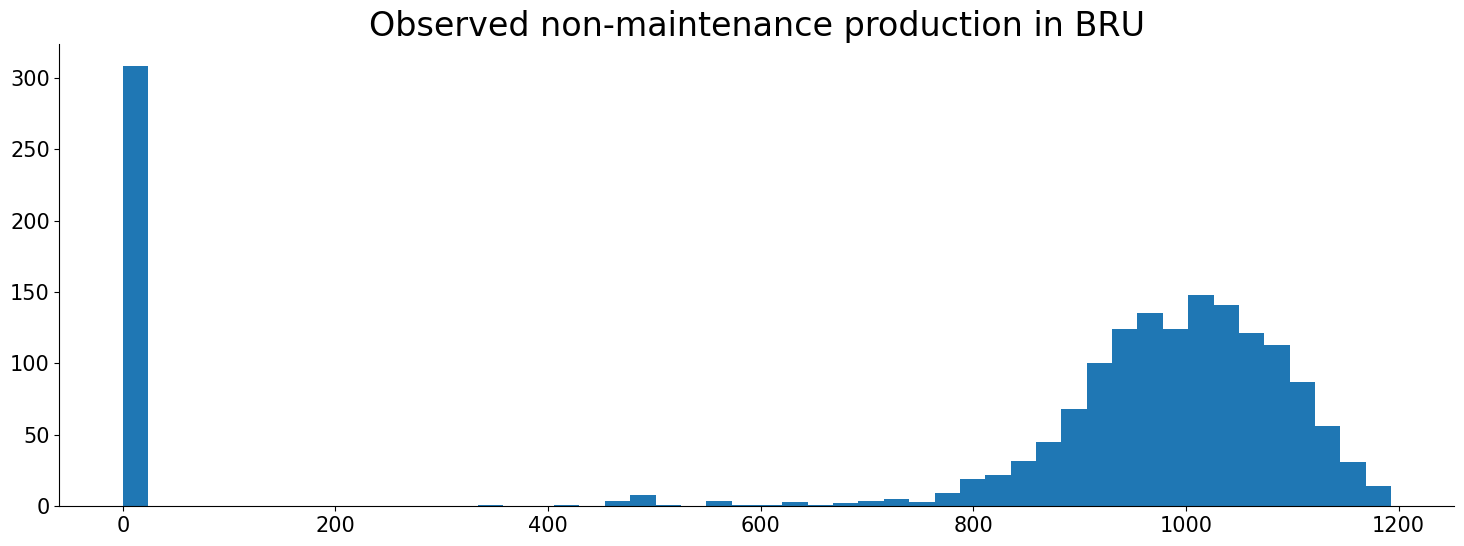

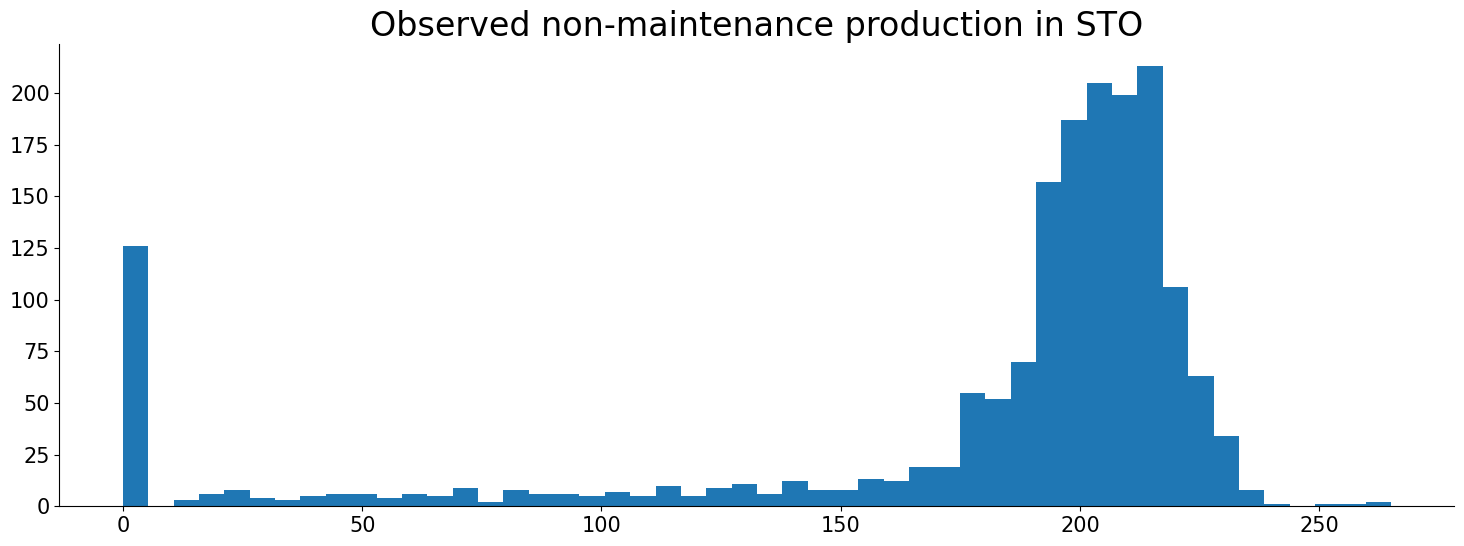

In [12]:
for facility, group in production_data_no_maintenance.groupby('facility'):
    group.production.hist(
        bins = binamount, 
        grid = False)
    plt.title(f"Observed non-maintenance production in {facility}")
    plt.show()

## DEEL 7

Gebruik je simulatieprogramma om de productiekansen over een periode van n dagen te simuleren. Maak
ook een grafiek waarin je de vorm van de empirische cdf: $$F(x) = P{X_n \leq x},$$ met $X_n$ de willekeurige
variabele die gelijk is aan de productie over $n$ (i.i.d.) dagen. Voor het bepalen van de ecdf kan je gebruik
maken van de functie scipy.stats.ecdf.
Pas je functie ook eens toe op een periode van 7 dagen. Je code zou er ongeveer zo uit moeten zien:

    
    import matplotlib.pyplot als plt
    import numpy als np
    xx = np.linspace(0, 10 ** 4)
    data = simulation(7)
    Fxx = cumulatieve_distribution_function(data, xx)
    plt.plot(xx, Fxx)
    


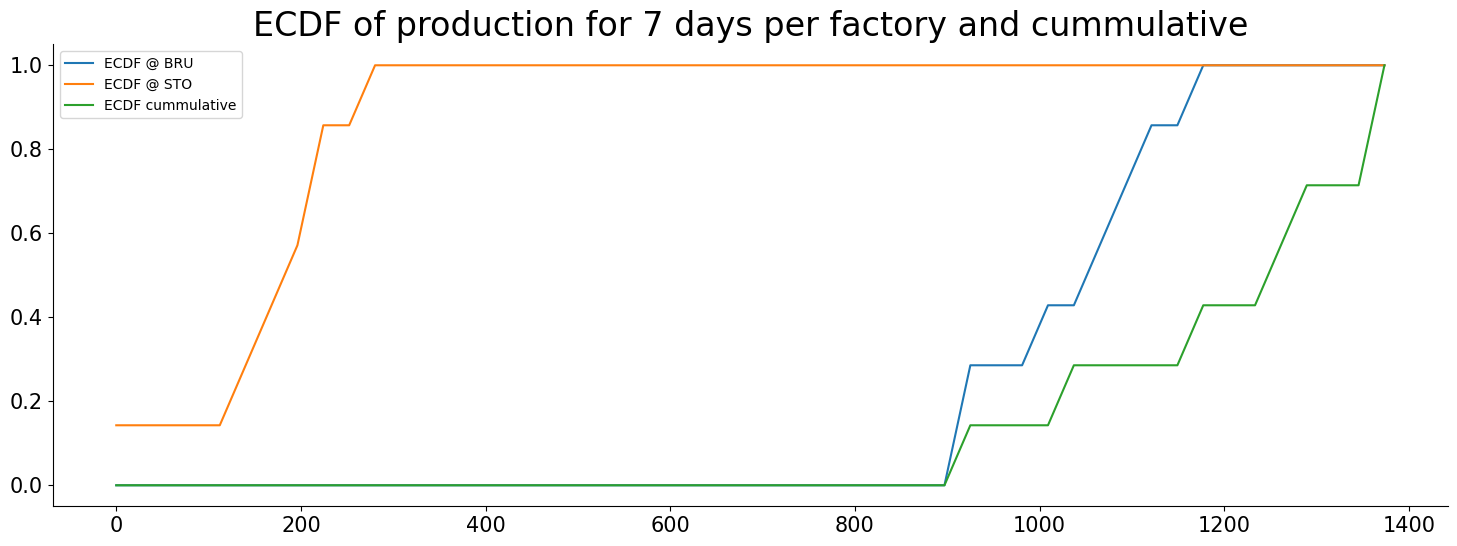

In [13]:
forecast_horizon = 7
# Step1 simulate for x days for both sites: 
week_forecast_per_factory = get_prod_estimate_per_facility(
    forecast_horizon, 
    no_production_chance, 
    predictions_per_facility, 
    prod_locations,
    False
    )
#step2: merge the data for all factories into a single list
forecast_data_total = merged_production(*list(week_forecast_per_factory.values()))
#low is 0 
#high is the max value for our quantile-borders
low = 0
high = max(forecast_data_total)
#quantile borders:
xx = np.linspace(low, high)
#pass the production data of both factories to an ECDF function  
#print(forecast_data_total)
ecdf_result = ECDF(forecast_data_total)
#also plot the individual forecasts per factory: 
for loc in prod_locations:
    location_data = week_forecast_per_factory[loc]
    location_ecdf = ECDF(location_data)
    Fxx_location = location_ecdf(xx)
    plt.plot(xx, Fxx_location, label=f"ECDF @ {loc}")
#and the quantiles you want to map that ecdf result to
Fxx = ecdf_result(xx)
plt.plot(xx, Fxx, label=f"ECDF cummulative")
plt.legend()
plt.gca().set_title(f"ECDF of production for {forecast_horizon} days per factory and cummulative")
plt.show()




## Central Limit Theorem   

Bekijk de verdeling die je bepaalde in de vorige stap. Deze geeft je de verdeling van de productie over een
aantal dagen. De centrale limietstelling zegt dat als je een groot aantal onafhankelijke waarnemingen samen
normaal verdeeld zijn. Kan je deze observatie visueel voorstellen door de empirische cdf te vergelijken met de
theoretische cdf van de normale verdeling, dit voor een stijgend aantal dagen n die je accumuleert?

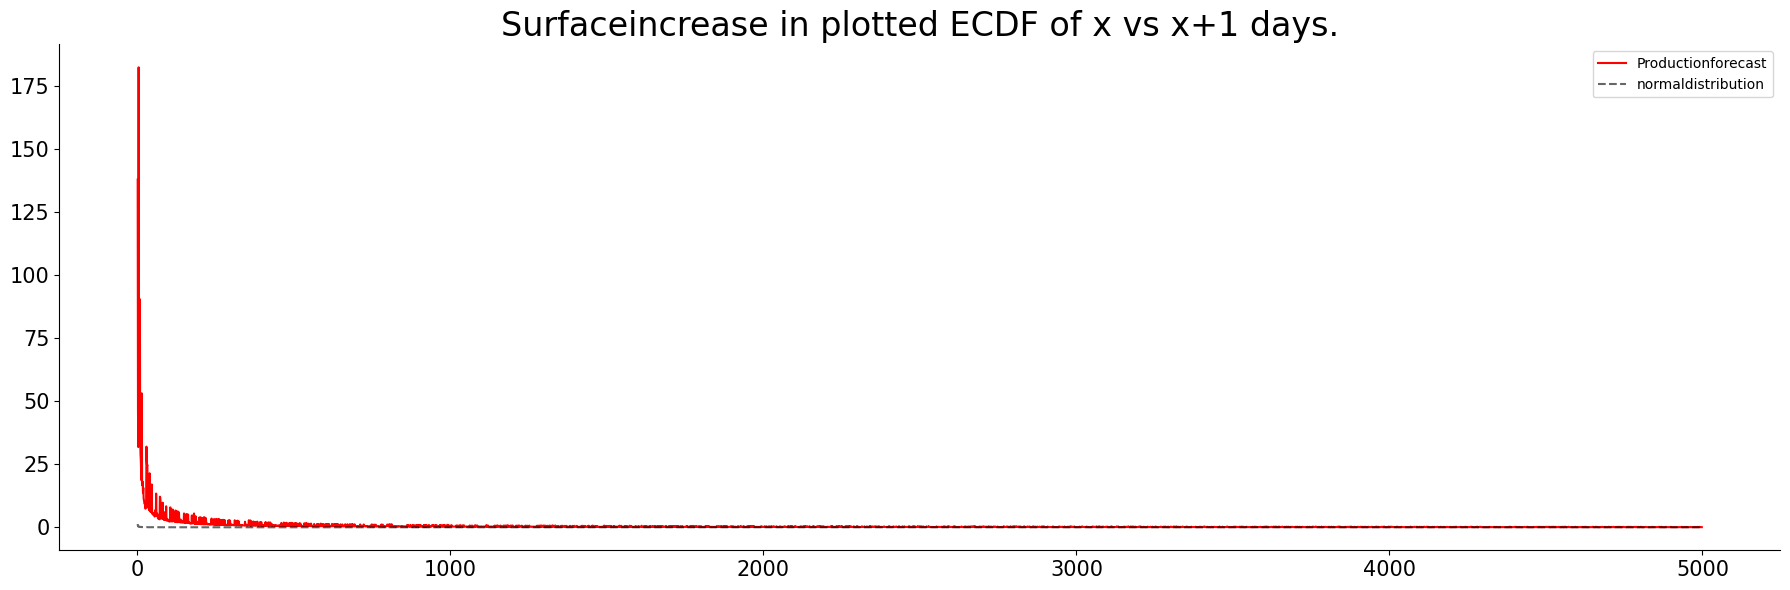

In [19]:
sim_len = 5000
forecast_data_per_factory_clt = get_prod_estimate_per_facility(
    sim_len, 
    no_production_chance, 
    predictions_per_facility, 
    prod_locations, 
    False
    )
#generate the data
forecast_data_total_clt = merged_production(*list(forecast_data_per_factory_clt.values()))
normdata = np.random.normal(0, 1, sim_len)

low = 0
high = max(forecast_data_total_clt)
xx_clt = np.linspace(low, high)
xx_norm = np.linspace(min(normdata), max(normdata))


basedays = []
areas = []
areas_norm = []

for i in range(1, len(forecast_data_total_clt)-1):
    #always add one more day to your forecast, without changing the days before i
    data1 = forecast_data_total_clt[:i]
    data2 = forecast_data_total_clt[:i+1]
    data1_norm = normdata[:i]
    data2_norm = normdata[:i+1]

    # Create the ECDF and calculate surface increase for productiondata
    ecdf1 = ECDF(data1)
    ecdf2 = ECDF(data2)
    Fxx = ecdf1(xx_clt)
    Fxx2 = ecdf2(xx_clt)
    area = simpson(x = xx_clt, y = np.abs(Fxx - Fxx2))
    basedays.append(i)
    areas.append(area)
    # Create the ECDF and calculate surface increase for normalized data
    ecdf1_norm = ECDF(data1_norm)
    ecdf2_norm = ECDF(data2_norm)
    Fxx_norm = ecdf1_norm(xx_norm)
    Fxx2_norm = ecdf2_norm(xx_norm)
    area_norm = simpson(x= xx_norm, y= np.abs(Fxx_norm - Fxx2_norm))
    areas_norm.append(area_norm)

plt.plot(basedays, areas, 'r', label='Productionforecast', alpha = 1)
plt.plot(basedays, areas_norm, 'k', label='normaldistribution', alpha = 0.6, linestyle='--')
plt.legend()
plt.title('Surfaceincrease in plotted ECDF of x vs x+1 days.')
plt.tight_layout()
plt.show()

Anything past 1000 Days already quite stable, there's not a lot of area being added to the ECDF chart generated using x+1-day as opposed to x-day. We can already see that anything past one thousand observations converges to the central limit theorem. To further show the graphs below show the ECDF for different  forecast horizons ranging from 7 to 1500 days. We see that the impact of adding new points on the surface of a plot diminishes as you add more and converges towards the behaviour of the same surface calculation applied to normally distributed data.

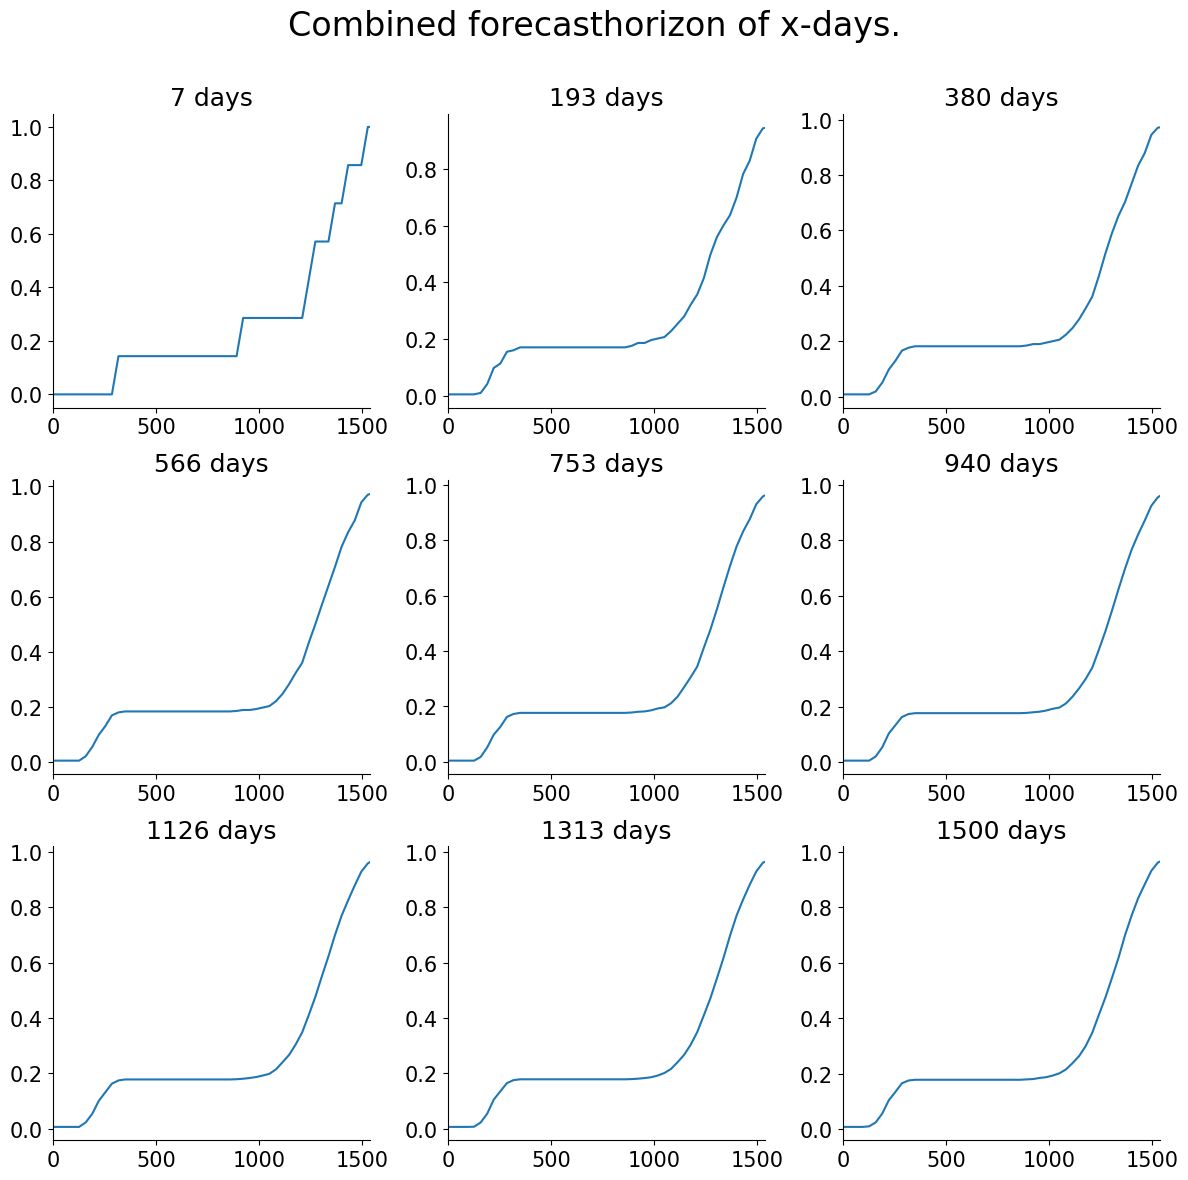

In [20]:
sample_cut_off = 1500
days = np.linspace(7, sample_cut_off, 9, dtype=int)
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
counter = 0
plotrow = -1    
for day in days: 
    if counter %3 == 0:
        plotrow +=1
    dataslice = forecast_data_total_clt[0:day]
    ecdf_sliding = ECDF(dataslice)
    low = 0
    high = max(forecast_data_total)
    #quantile borders:
    xx = np.linspace(low, high)
    Fxx = ecdf_sliding(xx)
    ax = axs[plotrow, counter%3]
    ax.plot(xx_clt, Fxx)
    ax.set_xlim(0,sample_cut_off*1.025)
    ax.set_title(f'{day} days', fontsize=18)
    # print(dataslice, len(dataslice))
    # break
    # print( day, counter, plotrow)
    counter+=1
fig.suptitle('Combined forecasthorizon of x-days.\n', fontsize = 24)
plt.tight_layout()

We can see it smoves out as you add more observations; we're still far off from a normal distribution because we have two factories with different volumes. We can also come to this conclusion by taking an increasing set of random samples from our forecast and plot out the average for this. The changes in the average should become less as you add more datapoints. This matches the behaviour where the plot smooths out. We'll reuse the data stored in ```forecast_data_total_clt``` with a forecast horizon of ```sim_len``` days for this. 


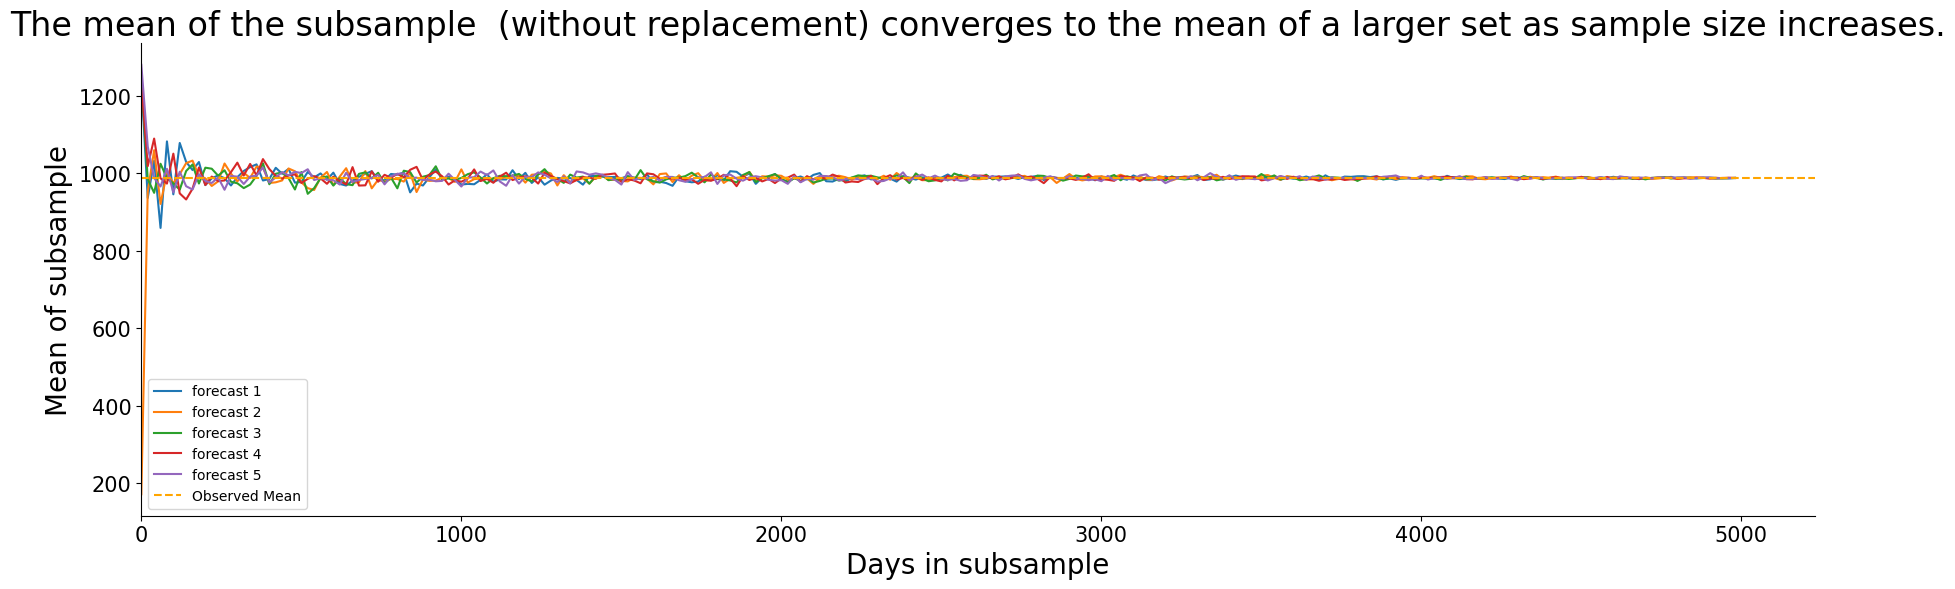

In [16]:
moving_mean_for_clt(
    forecast_data_total_clt, 
    np.ceil(len(forecast_data_total_clt)/250), 
    5, 
    False
    )


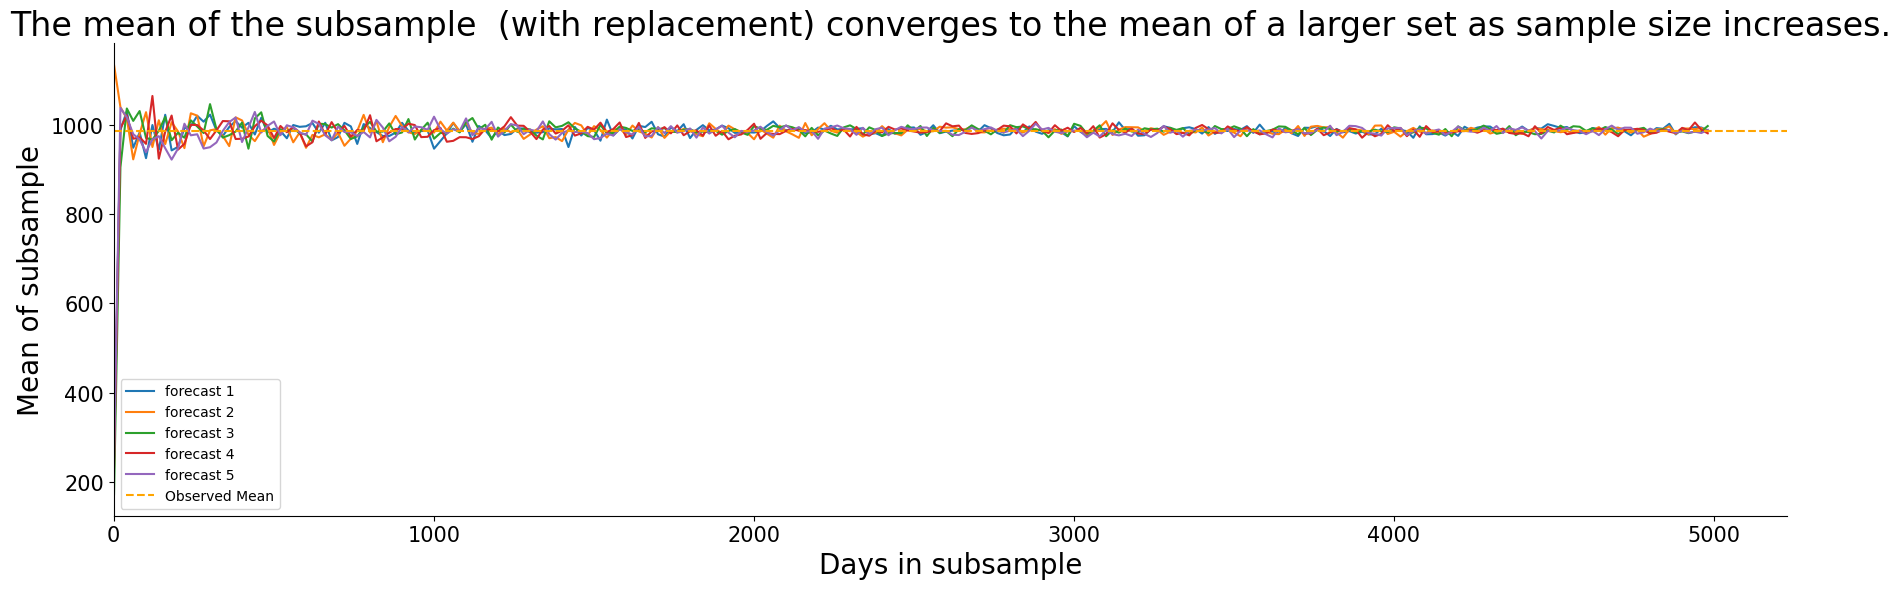

In [17]:
moving_mean_for_clt(
    forecast_data_total_clt, 
    np.ceil(len(forecast_data_total_clt)/250), 
    5, 
    True
    )

We can see that the mean in five simulations with independent subsamples from a larger shared population converge to the mean of the larger population. This behaviour can be seen for both plots, one representing subsamples without replacement and one with replacement. 

The graph with replacement is not super clear, we can drive the point home by going back to the forecast horizon of 100.000 days and plot it re-using our function. :

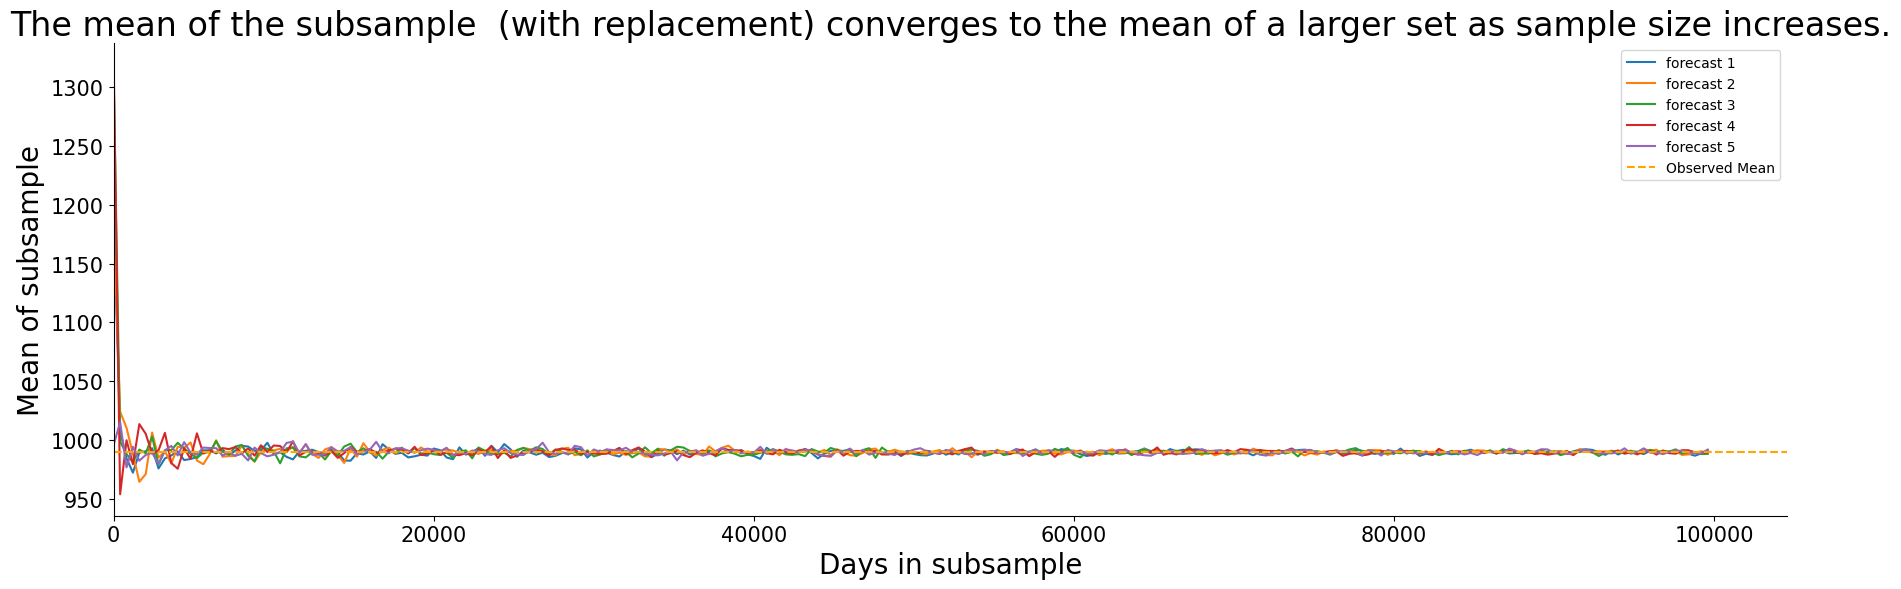

In [18]:
large_clt_proof = merged_production(*list(forecast_data_per_factory.values()))
moving_mean_for_clt(
    large_clt_proof, 
    np.ceil(len(large_clt_proof)/250), 
    5, 
    True
    )

Using a longer forecast horizon enables us to the convergance happening more clearly. 